In [1]:
import os, sys
sys.path.append(os.path.join('/home/ring/sumo-svn/', 'tools'))
import traci
import traci.constants as tc
import numpy as np
from sumolib import checkBinary
import datetime
import copy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import optparse
import pandas as pd
import asyncio
from collections import namedtuple
import random
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class NetworkA1(nn.Module):
    def __init__(self):
        super(NetworkA1, self).__init__()
        # [50, 60, 100, 0, .... , 20, 8]
        self.fc_layer1 = nn.Linear(10, 15) ##CHANGE!! 8
        self.fc_layer2 = nn.Linear(15, 20)
        self.fc_layer3 = nn.Linear(20, 2) ##CHANGE!! 2
    def forward(self, x):
        # x is input
        # Layer 1
        x = F.relu(self.fc_layer1(x))
        # Layer 2
        x = F.relu(self.fc_layer2(x))
        # Layer 3
        x = self.fc_layer3(x)
        return x
model1 = NetworkA1()

In [4]:
class NetworkA2(nn.Module):
    def __init__(self):
        super(NetworkA2, self).__init__()
        # [50, 60, 100, 0, .... , 20, 8]
        self.fc_layer1 = nn.Linear(11, 15) ##CHANGE!! 6
        self.fc_layer2 = nn.Linear(15, 20)
        self.fc_layer3 = nn.Linear(20, 3) ##CHANGE!! 4
    def forward(self, x):
        # x is input
        # Layer 1
        x = F.relu(self.fc_layer1(x))
        # Layer 2
        x = F.relu(self.fc_layer2(x))
        # Layer 3
        x = self.fc_layer3(x)
        return x
model2 = NetworkA2()

In [5]:
#reset the environment
def reset():
    sumoBinary = checkBinary('sumo') #-gui
    traci.start([sumoBinary, "-c", "map_grid_lock_add2TL_copy.sumocfg",
                             "--tripinfo-output", "tripinfo.xml", '--start','true','--quit-on-end','true','--time-to-teleport','-1'])

In [6]:
id = {'virtual' : '270329335' ,'KasemRat': 'cluster_272448137_272555800_272555808_7660045934_7710268409'}
detecters = {'QA' : ['156261350#0'], 'QB' : ['-453962283#3'], 'QC' : ['459551209#0', '459551209#3'], 'QD' : ['27702347#0', '27702347#4', '27702347#6']}

In [7]:
import sumolib
import lxml.etree as ET
def get_edge_id(POI):
    root = ET.Element('additionals')
    net = sumolib.net.readNet('map_grid_lock_add2TL_copy_newTLS.net.xml')
    output = []
    for key in POI:
        edgeID = net.getEdge(key)
        numOfLane = edgeID.getLaneNumber()
        for lane_index in range(numOfLane):
            output.append(key+'_'+str(lane_index))
    return output    

In [8]:
def get_state():
    occupancy = []
    for key in ['QA', 'QB', 'QC', 'QD']:
        occupancy.append(sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(detecters[key])])/len(get_edge_id(detecters[key])))
    current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
    for i in current_phase:
        current_phase_binary = [0, 0, 0]
        current_phase_binary[int(i//2)] = 1
        occupancy+= current_phase_binary
    return occupancy

In [9]:
reward_memory = []
def plot_durations():
    print('show')
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(reward_memory, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
def get_action_junction(current_state):
    if np.random.rand() < epsilon:
        action = np.random.randint(1)
    else:
        # Ask model what to do?        
        answer = policy_net1(torch.tensor(current_state))
        action = torch.argmax(answer)
    return action

In [11]:
def take_action(action, ID):
    w = 0.999
    act = [5, 1, 3]
    print(act[action])
    change_to_phase = (act[action]+1)%6
    if change_to_phase == traci.trafficlight.getPhase(id[junction_name[ID]]):
        traci.trafficlight.setPhase(id[junction_name[ID]], change_to_phase) # NO YELLOW PHASE 
    else:
        traci.trafficlight.setPhase(id[junction_name[ID]], act[action]) # YELLOW PHASE FIRST
    for i in range(5):
        traci.simulationStep()
#     w1 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     w2 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     reward = -w2*(1-w) - w1*(w)
    reward = -sum(get_state())
    print('reward', reward)
    next_state1 = get_state()
    junct = get_action_junction( next_state1)
    next_state2 = copy.deepcopy( next_state1)
    print('current_state2', next_state2)
    next_state2.append(int(junct))
    return reward, next_state1, next_state2

In [12]:
def get_action_phase(current_state):
    if np.random.rand() < epsilon:
        action = np.random.randint(2)
    else:
        # Ask model what to do?        
        answer = policy_net2(torch.tensor(current_state))
        action = torch.argmax(answer)
    return action

In [13]:
def initial(state1, state2, max_occupancy):
    occupancy = copy.deepcopy(state1[0:4])
    print(occupancy)
    s1 = copy.deepcopy(state1[4:7])
    s2 = copy.deepcopy(state1[7:9])
    if state1 == None and state2 == None:
        if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
            print(occupancy)
            print('set0')
            state2 = copy.deepcopy(state1)
            state2.append(0)
            traci.trafficlight.setPhase(id['virtual'], 2)
            junct = 0
            action = 1
        elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            state2 = copy.deepcopy(state1)
            state2.append(1)
            junct = 1
            action = 1
        elif occupancy[2] >= max_occupancy:
            print(occupancy)
            print('set2')
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            state2 = copy.deepcopy(state1)
            state2.append(1)
            junct = 1
            action = 1
        else:
            traci.trafficlight.setPhase(id['virtual'], 0)
            state2 = copy.deepcopy(state1)
            state2.append(0)
            junct = 1
            action = 0
    else:
        if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
            print(occupancy)
            print('set0')
            traci.trafficlight.setPhase(id['virtual'], 2)
            junct = 0
            action = 1
        elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junct = 1
            action = 1
        elif occupancy[2] >= max_occupancy:
            print(occupancy)
            print('set2')
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junct = 1
            action = 1
        else:
            traci.trafficlight.setPhase(id['virtual'], 0)
            junct = 1
            action = 0
    for i in range(5):
        traci.simulationStep()
    reward = -sum(get_state())
    next_state1 = get_state()
    next_state2 = copy.deepcopy(next_state1)
    if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
        next_state2.append(0)
    elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
        next_state2.append(1)
    elif occupancy[2] >= max_occupancy:
        next_state2.append(1)
    else:
        next_state2.append(0)
    
    return reward, state1, state2, action, junct, next_state1, next_state2

In [14]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
def optimize_model1():
    if len(memory1) < BATCH_SIZE:
        return

    transitions = memory1.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
#     print('non_final_mask', non_final_mask)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
#     print('non_final_next_states',  non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
#     print('state_batch', state_batch)
#     print('reward_batch', reward_batch)
#     print('action_batch', action_batch)
    state_action_values = policy_net1(state_batch).gather(1, action_batch)
#     print(state_action_values)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net1(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
#     print('state_action_values', state_action_values)
#     print('expected_state_action_values ', expected_state_action_values )

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer1.zero_grad()
    loss.backward()
    for param in policy_net1.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer1.step()

In [16]:
# non_final_mask = torch.tensor([True, True, True, True, True, True, True, True, True, True])
# non_final_next_states = torch.tensor([[ 7.1332,  6.4395, 22.7967,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 18.4670,  4.4428,  0.0000,  0.0000,  1.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 14.0199, 18.6225,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 16.0655, 23.2155,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 9.9864, 15.5202, 20.6725, 27.4631,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 9.9864, 16.2855, 21.2403, 34.1072,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 1.8350,  0.0000, 17.5268,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 21.6002, 11.9312,  0.0000,  0.0000,  1.0000,  0.0000,
#           1.0000,  0.0000,  0.0000],
#         [ 0.0000,  0.0000, 16.1663,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 14.5397, 37.0644,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000]])

# state_batch = torch.tensor([[ 1.8350,  0.0000, 17.5268,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 14.0199, 18.6225,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 7.1332,  6.4395, 22.7967,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 21.6002, 11.9312,  0.0000,  0.0000,  1.0000,  0.0000,
#           1.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 16.0655, 23.2155,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 9.9864, 15.5202, 20.6725, 27.4631,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 0.0000,  0.0000, 16.1663,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 18.4670,  4.4428,  0.0000,  0.0000,  1.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 0.0000,  0.0000,  8.8183,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.2855, 21.2403, 34.1072,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000]])
# action_batch = torch.tensor([[0],
#         [2],
#         [0],
#         [0],
#         [0],
#         [0],
#         [0],
#         [2],
#         [0],
#         [0]])
# reward_batch = torch.tensor([[0],
#         [2],
#         [0],
#         [0],
#         [0],
#         [0],
#         [0],
#         [2],
#         [0],
#         [0]])
# state_action_values = torch.tensor([[ 0.2508],
#         [-0.0413],
#         [ 0.1092],
#         [-0.0687],
#         [-0.0691],
#         [-0.0643],
#         [ 0.2510],
#         [-0.0855],
#         [ 0.2228],
#         [-0.0836]])
# state_action_values = torch.tensor([[ 0.2508],
#         [-0.0413],
#         [ 0.1092],
#         [-0.0687],
#         [-0.0691],
#         [-0.0643],
#         [ 0.2510],
#         [-0.0855],
#         [ 0.2228],
#         [-0.0836]])
# expected_state_action_values = torch.tensor([[-38.2710, -38.4463, -38.4064, -38.4315, -38.4271, -38.4445, -38.1435,
#          -38.4311, -38.1434, -38.4599],
#         [-50.8967, -51.0719, -51.0321, -51.0571, -51.0528, -51.0702, -50.7692,
#          -51.0568, -50.7691, -51.0856],
#         [-44.5306, -44.7058, -44.6659, -44.6910, -44.6867, -44.7040, -44.4031,
#          -44.6907, -44.4029, -44.7194],
#         [-67.2678, -67.4431, -67.4032, -67.4283, -67.4240, -67.4413, -67.1403,
#          -67.4279, -67.1402, -67.4567],
#         [-75.5440, -75.7192, -75.6794, -75.7044, -75.7001, -75.7175, -75.4165,
#          -75.7041, -75.4163, -75.7328],
#         [-83.5211, -83.6964, -83.6565, -83.6816, -83.6773, -83.6946, -83.3937,
#          -83.6813, -83.3935, -83.7100],
#         [-21.2635, -21.4388, -21.3989, -21.4240, -21.4197, -21.4370, -21.1361,
#          -21.4237, -21.1359, -21.4524],
#         [-61.5182, -61.6934, -61.6536, -61.6786, -61.6743, -61.6917, -61.3907,
#          -61.6783, -61.3905, -61.7070],
#         [-18.0681, -18.2433, -18.2035, -18.2285, -18.2242, -18.2416, -17.9406,
#          -18.2282, -17.9404, -18.2570],
#         [-79.5910, -79.7663, -79.7264, -79.7515, -79.7471, -79.7645, -79.4635,
#          -79.7511, -79.4634, -79.7799]])
# state_action_values = policy_net2(state_batch).gather(1, action_batch)
# next_state_values = torch.zeros(BATCH_SIZE)
# print(next_state_values)
# next_state_values[non_final_mask] = target_net2(non_final_next_states).max(1)[0].detach()
# print(next_state_values[non_final_mask])
# print(state_action_values)
#     # Compute the expected Q values
# expected_state_action_values = (next_state_values * GAMMA) + reward_batch
# print(expected_state_action_values)

In [17]:
def optimize_model2():
    if len(memory2) < BATCH_SIZE:
        return
#     print(len(memory2))
    transitions = memory2.sample(BATCH_SIZE)
#     print(type(zip(*transitions)))
#     print(type(Transition(*zip(*transitions))))
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
#     print('non_final_mask', non_final_mask)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
#     print('non_final_next_states',  non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
#     print('state_batch', state_batch)
#     print('reward_batch', reward_batch)
#     print('action_batch', action_batch)
    state_action_values = policy_net2(state_batch).gather(1, action_batch)
#     print(state_action_values)
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net2(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
#     print('state_action_values', state_action_values)
#     print('expected_state_action_values ', expected_state_action_values )
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer2.zero_grad()
    loss.backward()
    for param in policy_net2.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer2.step()

In [18]:
junction_name = ['virtual','KasemRat']

time_step = 5
reward = 0 
epsilon = 0.1 # ดมกาว 10%
GAMMA = 0.9  #GAMMA = [e for e in gamma()] ภีมเปลี่ยนเอาเองนะถ้าอยากเปลี่ยน

action = 0
current_state1 = None
previous_state1 = None

memory = []
BATCH_SIZE = 16

start_training_step = 10
current_training_step = 0 

alpha = 0.1

# create your optimizer
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
criterion = nn.MSELoss()

policy_net1 = model1
target_net1 = model1
target_net1.load_state_dict(policy_net1.state_dict())
target_net1.eval()
optimizer1 = optim.RMSprop(policy_net1.parameters())

policy_net2 = model2
target_net2 = model2
target_net2.load_state_dict(policy_net2.state_dict())
target_net2.eval()
optimizer2 = optim.RMSprop(policy_net2.parameters())

memory1 = ReplayMemory(10000)
memory2 = ReplayMemory(10000)
TARGET_UPDATE = 10

steps_done = 0

In [19]:
traci.close()

FatalTraCIError: Not connected.

In [19]:
#episode = 0
state1 = None
state2 = None
rewards = 0
reset()
traci.simulationStep()
state1 = get_state()
for seconds in range(100):
    reward, current_state1, current_state2, action, junct, next_state1, next_state2 = initial(state1, state2, 50)
    if state1 is not None and state2 is not None:
        memory1.push(torch.tensor([current_state1]), torch.tensor([[junct]]), torch.tensor([next_state1]), torch.tensor([reward]))
        memory2.push(torch.tensor([current_state2]), torch.tensor([[action]]), torch.tensor([next_state2]), torch.tensor([reward]))
    state1 = next_state1
    state2 = next_state2
    optimize_model1()
    optimize_model2()
    rewards += reward
reward_memory.append(rewards)
traci.close()

[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 2.5534435288280672, 0.0]
[0.0, 0.0, 4.128436187870073, 0.0]
[0.0, 0.0, 5.360007619733439, 0.0]
[0.0, 0.0, 7.335554320628493, 0.0]
[1.4266304347826089, 0.0, 7.361006425994372, 0.0]
[2.8532608695652177, 0.0, 7.029373974816924, 0.0]
[4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0]
[6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0]
[8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0]
[8.559782608695654, 9.65920970102446, 6.719999162874282, 1.110710421925712]
[8.559782608695654, 11.595745894221023, 7.038136566591669, 2.221420843851424]
[8.559782608695654, 12.878946268032616, 7.1939842904586175, 5.9106570018954185]
[8.559782608695654, 10.229346310926609, 6.735672595005193, 7.004811409878859]
[8.559782608695654, 9.65920970102446, 7.677412051252616, 9.709760056337686]
[7.133152173913045, 11.523877672587577, 7.229926196770727, 10.67339564221237]
[7.133152173913045, 11.833147986653076, 7.272577863477096, 15.94440992261542]
[7.

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -13.470738732939274
current_state2 [2.8532608695652177, 0.0, 8.617477863374056, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -20.64331417432392
current_state2 [4.279891304347826, 3.219736567008154, 11.14368630296794, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -23.146953531728478
current_state2 [6.437237981972113, 3.219736567008154, 11.489978982748212, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -27.675763466929688
current_state2 [8.559782608695654, 3.219736567008154, 13.89624429122588, 0.0, 0, 1, 0, 0, 0, 1]
3
reward -26.6933

reward -108.19524073868197
current_state2 [29.959239130434796, 11.685599122168895, 34.858247048963314, 29.69215543711496, 0, 1, 0, 0, 1, 0]
1
reward -112.142984405778
current_state2 [29.959239130434796, 13.00410238960899, 39.60422793521845, 27.575414950515768, 0, 1, 0, 0, 1, 0]
5
reward -114.99126162970698
current_state2 [29.959239130434796, 16.09868283504077, 41.26853510418073, 25.664804560050683, 0, 1, 0, 1, 0, 0]
5
reward -111.22234676381004
current_state2 [29.959239130434796, 16.09868283504077, 37.71728170476996, 25.447143093564506, 0, 1, 0, 1, 0, 0]
1
reward -109.32002268342025
current_state2 [29.959239130434796, 16.09868283504077, 35.4495769662045, 25.812523751740187, 0, 1, 0, 0, 1, 0]
1
reward -108.9526733266395
current_state2 [29.959239130434796, 12.878946268032616, 36.843332595089265, 27.271155333082834, 0, 0, 1, 0, 1, 0]
1
reward -104.33991279349297
current_state2 [28.532608695652183, 9.65920970102446, 36.875101301119656, 27.272993095696677, 0, 0, 1, 0, 1, 0]
5
reward -107.64

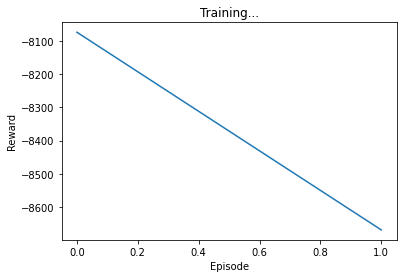

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.4021

reward -57.691172383559035
current_state2 [14.266304347826086, 12.878946268032616, 12.790253673097965, 15.755668094602372, 0, 1, 0, 1, 0, 0]
1
reward -54.413236997610404
current_state2 [14.266304347826086, 9.65920970102446, 12.54331302614444, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -50.87311325246687
current_state2 [14.266304347826086, 9.952161347252654, 12.597687866795471, 12.056959690592654, 0, 1, 0, 0, 1, 0]
1
reward -49.931261203275994
current_state2 [14.266304347826086, 9.65920970102446, 9.17204765373574, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -56.25782783250311
current_state2 [13.885295562934436, 14.822679277628945, 13.278123213426035, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -53.26166324884507
current_state2 [14.266304347826086, 12.878946268032616, 12.014912963594277, 12.101499669392089, 0, 1, 0, 0, 1, 0]
1
reward -55.47978955729872
current_state2 [14.266304347826086, 12.878946268032616, 11.586736644945212, 14.74780229649481, 0, 0, 1, 0, 1, 0]
1
reward -53.640

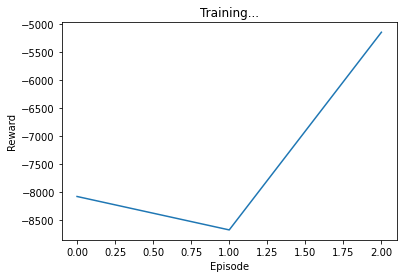

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -13.96583417316941
current_state2 [4.279891304347826, 0.0, 7.685942868821584, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -17.64625746901287
current_state2 [5.7065217391304355, 3.219736567008154, 6.719999162874282, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -28.307813820632038
current_state2 [8.559782608695654, 9.65920970102446, 8.088821510911924, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -35.79798112216695
curre

reward -53.847918014369306
current_state2 [15.692934782608695, 13.196143366413471, 12.681813861792026, 10.277026003555116, 0, 1, 0, 1, 0, 0]
5
reward -59.71457881953701
current_state2 [15.692934782608695, 12.878946268032616, 15.097734427557006, 14.044963341338695, 0, 1, 0, 1, 0, 0]
1
reward -54.81432270330916
current_state2 [14.266304347826086, 10.38953181069231, 13.340575233199164, 14.817911311591601, 0, 1, 0, 0, 1, 0]
1
reward -57.0284745921696
current_state2 [14.266304347826086, 12.167827432968018, 14.085176295960268, 14.50916651541523, 0, 1, 0, 0, 1, 0]
1
reward -59.78250761638108
current_state2 [14.266304347826086, 12.878946268032616, 14.217535684943053, 16.419721315579334, 0, 1, 0, 0, 1, 0]
1
reward -49.289501447138825
current_state2 [14.266304347826086, 9.65920970102446, 10.124526122131687, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -52.17559603677618
current_state2 [14.266304347826086, 12.878946268032616, 10.073023946402131, 12.957321474515345, 0, 0, 1, 0, 1, 0]
1
reward -5

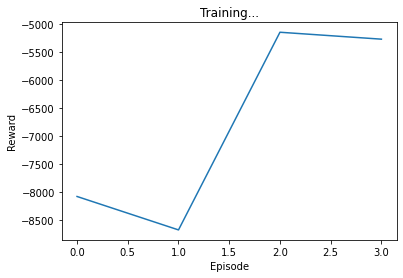

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -25.30

reward -67.46195409377651
current_state2 [12.839673913043478, 16.09868283504077, 10.48529986145212, 26.038297484240143, 0, 1, 0, 0, 1, 0]
1
reward -61.919660525949
current_state2 [12.839673913043478, 15.627304127002922, 9.472516371209128, 21.98016611469347, 0, 1, 0, 0, 1, 0]
5
reward -61.40624544411834
current_state2 [12.839673913043478, 16.001948567588663, 12.648577193776521, 17.91604576970968, 0, 1, 0, 1, 0, 0]
5
reward -68.58113755565522
current_state2 [12.839673913043478, 18.35309268166354, 13.363973663646455, 22.024397297301743, 0, 1, 0, 1, 0, 0]
5
reward -63.456636671157014
current_state2 [12.839673913043478, 15.66403675640695, 14.832036526337596, 18.120889475368994, 0, 1, 0, 1, 0, 0]
1
reward -64.77699996111998
current_state2 [12.839673913043478, 12.176518992310974, 14.177378770598004, 23.583428285167525, 0, 1, 0, 0, 1, 0]
1
reward -64.0065087369016
current_state2 [12.839673913043478, 12.878946268032616, 15.21953918885807, 21.06834936696744, 0, 0, 1, 0, 1, 0]
1
reward -59.468009

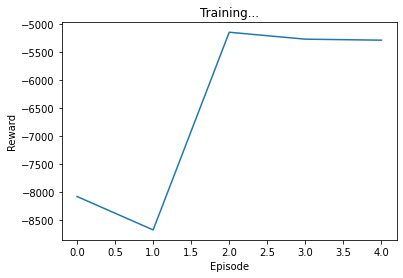

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -65.49117373890121
current_state2 [12.839673913043478, 12.878946268032616, 12.745566198190316, 25.0269873596348, 0, 1, 0, 0, 1, 0]
1
reward -62.124643523992745
current_state2 [12.839673913043478, 12.878946268032616, 12.549435697332923, 21.856587645583733, 0, 1, 0, 0, 1, 0]
1
reward -55.89141120447019
current_state2 [11.543451273763658, 12.878946268032616, 13.129085720286227, 16.339927942387693, 0, 1, 0, 0, 1, 0]
1
reward -58.432700575669514
current_state2 [12.839673913043478, 12.878946268032616, 11.065734929832434, 19.648345464760983, 0, 1, 0, 0, 1, 0]
5
reward -62.79320428231998
current_state2 [12.839673913043478, 12.878946268032616, 15.889155559529048, 19.18542854171484, 0, 1, 0, 1, 0, 0]
1
reward -56.93328666260923
current_state2 [12.839673913043478, 10.402673469566395, 17.270184519805717, 14.420754760193637, 0, 1, 0, 0, 1, 0]
1
reward -59.75275626804991
current_state2 [12.839673913043478, 12.878946268032616, 13.448643439058781, 18.585492647915036, 0, 0, 1, 0, 1, 0]
1
reward 

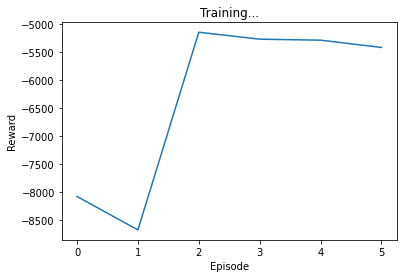

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -21.255227432433223
current_state2 [5.742048812853463, 6.439473134016308, 7.073705485563449, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.510570942619076
current_state2 [8.559782608695654, 12.878946268032616, 7.071842065890805, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -24.8

reward -67.34967380107817
current_state2 [14.266304347826086, 16.09868283504077, 22.669887642491506, 12.31479897571981, 0, 1, 0, 1, 0, 0]
1
reward -66.69703427250494
current_state2 [12.839673913043478, 15.213655890337913, 23.537780338257864, 13.105924130865686, 0, 1, 0, 0, 1, 0]
1
reward -68.66162923781334
current_state2 [12.839673913043478, 14.939447431075603, 20.551871222397953, 18.3306366712963, 0, 1, 0, 0, 1, 0]
1
reward -66.7494833114453
current_state2 [12.839673913043478, 14.143592580130942, 19.414899019884956, 18.351317798385924, 0, 1, 0, 0, 1, 0]
1
reward -66.37489202918876
current_state2 [12.839673913043478, 16.229867370720825, 19.656299493421965, 15.649051252002499, 0, 1, 0, 0, 1, 0]
1
reward -64.60162841600363
current_state2 [12.839673913043478, 16.09868283504077, 15.962375882245823, 17.700895785673563, 0, 1, 0, 0, 1, 0]
1
reward -63.65608167101149
current_state2 [12.839673913043478, 14.784235640852284, 15.581246362414678, 18.450925754701043, 0, 0, 1, 0, 1, 0]
1
reward -57.3

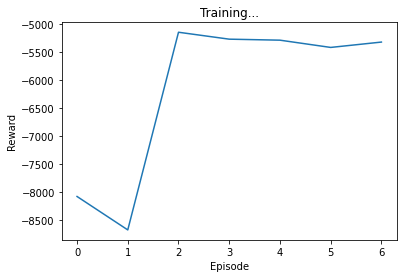

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.

reward -67.77836977109894
current_state2 [12.839673913043478, 16.09868283504077, 17.018120976206454, 19.82189204680824, 0, 1, 0, 0, 1, 0]
1
reward -61.1632917525494
current_state2 [12.839673913043478, 16.09868283504077, 14.142364702080084, 16.08257030238507, 0, 1, 0, 0, 1, 0]
5
reward -63.803178133026385
current_state2 [12.839673913043478, 15.877664337843033, 19.846378605983276, 13.239461276156595, 0, 1, 0, 1, 0, 0]
1
reward -68.74872114014066
current_state2 [11.413043478260871, 17.478399734423324, 21.06919640408315, 16.78808152337331, 0, 1, 0, 0, 1, 0]
1
reward -53.61598261108622
current_state2 [11.413043478260871, 9.65920970102446, 18.225034100182818, 12.318695331618068, 0, 1, 0, 0, 1, 0]
1
reward -59.95080967867925
current_state2 [11.413043478260871, 14.716046098489366, 15.877310179313586, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -60.6353443185363
current_state2 [12.839673913043478, 12.878946268032616, 15.189518678583438, 17.727205458876767, 0, 0, 1, 0, 1, 0]
1
reward -62.53492

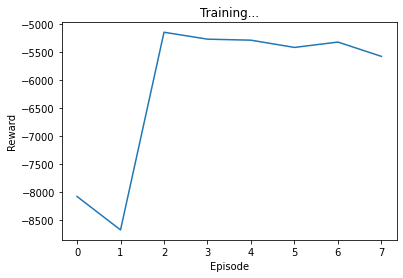

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -14.151938785135611
current_state2 [4.279891304347826, 0.0, 7.872047480787785, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -18.532420860301595
current_state2 [6.5926851304191585, 3.219736567008154, 6.719999162874282, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.89161067587369
current_state2 [8.559782608695654, 9.65920970102446, 7.672618366153576, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -33.69271819484632
curr

reward -58.63830699989131
current_state2 [15.692934782608695, 9.65920970102446, 15.484731517925555, 15.801430998332604, 0, 1, 0, 1, 0, 0]
5
reward -70.21508488146073
current_state2 [17.1195652173913, 15.574955702498142, 15.760494970571322, 19.760068990999958, 0, 1, 0, 1, 0, 0]
1
reward -62.64658629923685
current_state2 [17.1195652173913, 13.676556876022387, 15.016764705133458, 14.83369950068971, 0, 1, 0, 0, 1, 0]
5
reward -66.24058508321473
current_state2 [15.692934782608695, 14.088676279137125, 19.625274520779193, 14.83369950068971, 0, 1, 0, 1, 0, 0]
1
reward -68.86155011867683
current_state2 [15.692934782608695, 16.09868283504077, 19.955946252057988, 15.113986248969388, 0, 1, 0, 0, 1, 0]
5
reward -59.745941980021655
current_state2 [15.692934782608695, 9.65920970102446, 16.906624525952118, 15.487172970436385, 0, 1, 0, 1, 0, 0]
1
reward -61.25104311789245
current_state2 [15.692934782608695, 9.65920970102446, 19.548726936176987, 14.350171698082306, 0, 0, 1, 0, 1, 0]
1
reward -62.4216403

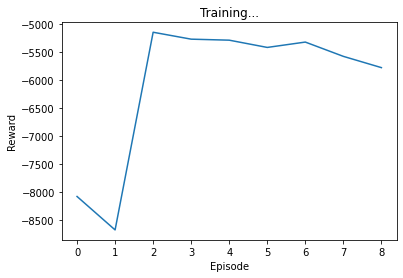

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -70.7397384549199
current_state2 [15.692934782608695, 19.31841940204892, 18.2451788607068, 15.483205409555476, 0, 1, 0, 0, 1, 0]
1
reward -64.60811006742338
current_state2 [15.20398022699467, 16.09868283504077, 15.361037082772516, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -58.31074724070987
current_state2 [14.266304347826086, 12.878946268032616, 13.07810777795294, 16.087388846898236, 0, 1, 0, 0, 1, 0]
1
reward -55.075135252010824
current_state2 [14.266304347826086, 9.65920970102446, 14.55205900914135, 14.597562194018929, 0, 1, 0, 0, 1, 0]
1
reward -52.38683088314621
current_state2 [14.266304347826086, 9.65920970102446, 13.078876633856257, 13.38244020043941, 0, 1, 0, 0, 1, 0]
5
reward -59.877394489391385
current_state2 [14.266304347826086, 16.09868283504077, 13.055353947374492, 14.457053359150036, 0, 1, 0, 1, 0, 0]
5
reward -61.249048478923285
current_state2 [15.692934782608695, 15.546754101336962, 11.886874523598177, 16.122485071379447, 0, 0, 1, 1, 0, 0]
1
reward -68.6541266

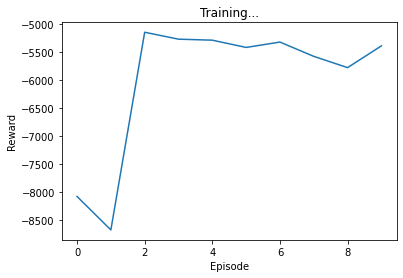

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.549374871198907
current_state2 [5.7065217391304355, 6.439473134016308, 6.403379998052165, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.538184955853634
current_state2 [8.559782608695654, 9.65920970102446, 7.319192646133518, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.602

reward -54.88152458216493
current_state2 [12.839673913043478, 12.878946268032616, 13.92344312493224, 13.239461276156595, 0, 1, 0, 0, 1, 0]
3
reward -52.601729125719125
current_state2 [11.413043478260871, 8.6825832667297, 15.585466401927464, 14.920635978801089, 0, 1, 0, 0, 0, 1]
3
reward -57.966406196451366
current_state2 [12.839673913043478, 11.691537772119853, 16.09671045108091, 15.338484060207128, 0, 1, 0, 0, 0, 1]
3
reward -62.32553236749588
current_state2 [12.839673913043478, 9.65920970102446, 20.375045328660214, 17.45160342476773, 0, 1, 0, 0, 0, 1]
5
reward -58.47073792283308
current_state2 [12.839673913043478, 6.439473134016308, 21.64716027043005, 15.544430605343246, 0, 1, 0, 1, 0, 0]
1
reward -55.49795067868615
current_state2 [12.839673913043478, 2.475854448769068, 20.374428827733727, 17.807993489139875, 0, 1, 0, 0, 1, 0]
1
reward -56.80346489308003
current_state2 [12.839673913043478, 0.0, 22.349736855634493, 19.614054124402063, 0, 0, 1, 0, 1, 0]
5
reward -60.46730333285545
curr

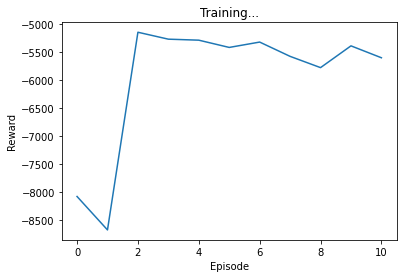

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -13.96583417316941
current_state2 [4.279891304347826, 0.0, 7.685942868821584, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -17.731672637891304
current_state2 [5.7065217391304355, 3.219736567008154, 6.805414331752714, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -28.10260415345134
current_state2 [8.559782608695654, 9.65920970102446, 7.883611843731226, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -34.27203915848518
curre

reward -66.57882253727203
current_state2 [14.266304347826086, 13.604562595635826, 16.60755544350916, 20.100400150300963, 0, 1, 0, 0, 1, 0]
1
reward -61.019747618445244
current_state2 [14.266304347826086, 13.649545522596156, 13.90556291696636, 17.19833483105664, 0, 1, 0, 0, 1, 0]
5
reward -60.33405815652662
current_state2 [14.266304347826086, 16.15775398468127, 13.192599550800056, 14.717400273219212, 0, 1, 0, 1, 0, 0]
5
reward -69.8508913687359
current_state2 [14.266304347826086, 16.09868283504077, 19.273686068750628, 18.21221811711842, 0, 1, 0, 1, 0, 0]
1
reward -62.34138747954013
current_state2 [14.266304347826086, 16.09868283504077, 17.70467051815958, 12.271729778513697, 0, 1, 0, 0, 1, 0]
5
reward -62.41440792229604
current_state2 [14.266304347826086, 16.09868283504077, 15.21572123873948, 14.83369950068971, 0, 1, 0, 1, 0, 0]
1
reward -66.82401352243834
current_state2 [14.266304347826086, 12.878946268032616, 17.836960548925973, 19.84180235765366, 0, 0, 1, 0, 1, 0]
1
reward -64.9699800

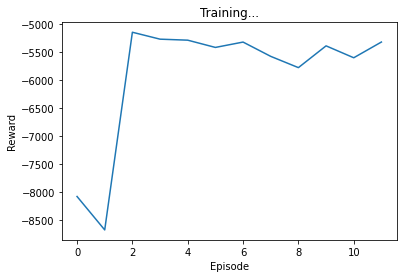

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -62.27278410006622
current_state2 [15.692934782608695, 12.878946268032616, 13.051544480350655, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -59.883351309524336
current_state2 [17.1195652173913, 12.878946268032616, 12.011152393612122, 15.873687430488296, 0, 1, 0, 0, 1, 0]
1
reward -54.09779469577232
current_state2 [17.1195652173913, 9.65920970102446, 13.898326160371964, 11.420693616984595, 0, 1, 0, 0, 1, 0]
1
reward -59.45975286459187
current_state2 [17.1195652173913, 9.65920970102446, 14.824960805864379, 15.856017140311728, 0, 1, 0, 0, 1, 0]
1
reward -59.676472086590515
current_state2 [17.1195652173913, 12.878946268032616, 11.733550678551174, 15.94440992261542, 0, 1, 0, 0, 1, 0]
5
reward -63.988885654471794
current_state2 [18.54619565217391, 14.110161040560188, 12.182534336315959, 17.149994625421733, 0, 1, 0, 1, 0, 0]
5
reward -65.17400279062197
current_state2 [18.54619565217391, 9.65920970102446, 15.336576858926234, 19.63202057849736, 0, 0, 1, 1, 0, 0]
1
reward -64.20608116025

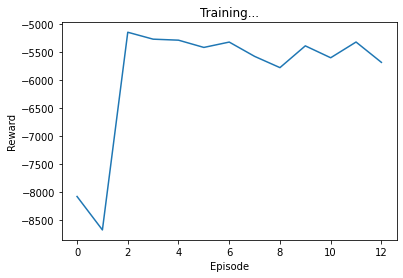

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -25.30

reward -64.0270344777771
current_state2 [14.266304347826086, 16.09868283504077, 11.460970124248071, 20.20107717066217, 0, 1, 0, 0, 1, 0]
1
reward -55.72461943564907
current_state2 [14.266304347826086, 9.65920970102446, 10.062269696988137, 19.736835689810384, 0, 1, 0, 0, 1, 0]
1
reward -59.97840433379214
current_state2 [14.266304347826086, 9.65920970102446, 11.730851571765628, 22.32203871317597, 0, 1, 0, 0, 1, 0]
5
reward -62.34795062458899
current_state2 [14.266304347826086, 12.878946268032616, 13.72657601541616, 19.476123993314133, 0, 1, 0, 1, 0, 0]
1
reward -63.43615070277734
current_state2 [15.692934782608695, 16.09868283504077, 12.248863862262164, 17.395669222865717, 0, 1, 0, 0, 1, 0]
1
reward -55.61965429548513
current_state2 [15.692934782608695, 12.191233675859166, 10.901786336327557, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -56.53333449205944
current_state2 [15.692934782608695, 8.816282985564479, 13.667334587673787, 16.356782136212484, 0, 0, 1, 0, 1, 0]
1
reward -52.7582756

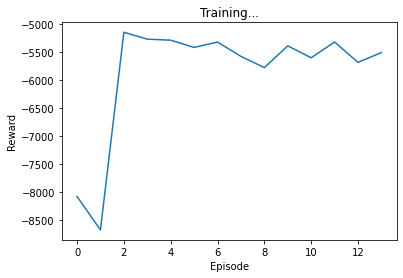

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.55

reward -65.57545885713675
current_state2 [12.839673913043478, 16.09868283504077, 12.350329976251736, 22.286772132800767, 0, 1, 0, 0, 1, 0]
1
reward -57.94896365120229
current_state2 [14.266304347826086, 9.838025246382768, 12.227543990276287, 19.617090066717143, 0, 1, 0, 0, 1, 0]
1
reward -50.61589804308126
current_state2 [14.266304347826086, 3.219736567008154, 13.838518627833926, 17.29133850041309, 0, 1, 0, 0, 1, 0]
1
reward -49.655259562777346
current_state2 [14.266304347826086, 3.219736567008154, 12.705629533049136, 17.46358911489397, 0, 1, 0, 0, 1, 0]
5
reward -59.261064765771906
current_state2 [17.1195652173913, 9.65920970102446, 12.205764402800565, 18.276525444555574, 0, 1, 0, 1, 0, 0]
1
reward -59.48564540593311
current_state2 [18.54619565217391, 16.09868283504077, 10.68308195933376, 12.157684959384667, 0, 1, 0, 0, 1, 0]
1
reward -68.62138622182387
current_state2 [19.407159807185657, 16.963503196437838, 14.30631329558496, 15.94440992261542, 0, 0, 1, 0, 1, 0]
1
reward -61.32325769

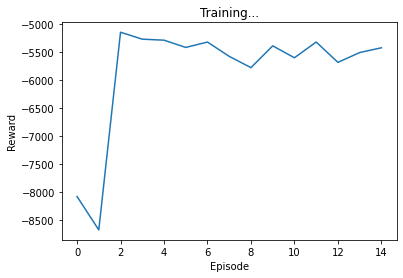

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.0918299842341
current_state2 [2.8532608695652177, 0.0, 7.238569114668882, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -14.704517485738425
current_state2 [4.279891304347826, 0.0, 8.424626181390598, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -18.6880455887502
current_state2 [5.7065217391304355, 3.219736567008154, 7.761787282611609, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -25.5610474617685
current_state2 [8.559782608695654, 6.439473134016308, 8.561791719056536, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -31.134068431111157
current

reward -63.90682557643609
current_state2 [12.839673913043478, 12.878946268032616, 14.110798977263173, 22.077406418096825, 0, 1, 0, 1, 0, 0]
5
reward -52.42284912031644
current_state2 [12.839673913043478, 6.439473134016308, 11.019541691799793, 20.124160381456857, 0, 1, 0, 1, 0, 0]
1
reward -55.89757199992425
current_state2 [12.839673913043478, 6.439473134016308, 14.762082657766141, 19.85634229509832, 0, 1, 0, 0, 1, 0]
1
reward -59.677940617912554
current_state2 [11.413043478260871, 9.65920970102446, 14.866501966340715, 21.739185472286504, 0, 1, 0, 0, 1, 0]
5
reward -60.548448493280134
current_state2 [12.839673913043478, 11.0922058721314, 14.923166207840621, 19.693402500264636, 0, 1, 0, 1, 0, 0]
1
reward -63.29202922455782
current_state2 [12.839673913043478, 12.878946268032616, 15.546427597500902, 20.026981445980827, 0, 1, 0, 0, 1, 0]
1
reward -62.086236734659266
current_state2 [12.839673913043478, 12.878946268032616, 15.836541895374108, 18.531074658209068, 0, 0, 1, 0, 1, 0]
1
reward -56

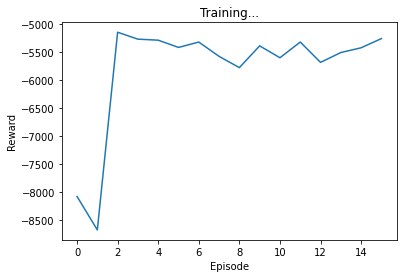

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -26.399147544496568
current_state2 [7.133152173913045, 9.65920970102446, 7.606785669559063, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -24.0159

reward -60.030153432059464
current_state2 [7.133152173913045, 13.580288865437645, 15.47676389594891, 21.839948496759863, 0, 1, 0, 0, 1, 0]
3
reward -57.90060253403975
current_state2 [7.133152173913045, 9.65920970102446, 18.093387123501138, 21.01485353560111, 0, 1, 0, 0, 0, 1]
3
reward -51.99918519172441
current_state2 [7.133152173913045, 3.219736567008154, 19.90519974140203, 19.741096709401184, 0, 1, 0, 0, 0, 1]
3
reward -59.62526261422103
current_state2 [7.133152173913045, 3.219736567008154, 26.06104558204958, 21.211328291250258, 0, 1, 0, 0, 0, 1]
1
reward -57.59466313079018
current_state2 [8.191007929003122, 3.219736567008154, 26.32125922291544, 17.862659411863458, 0, 1, 0, 0, 1, 0]
1
reward -56.01009776271796
current_state2 [9.986413043478262, 3.219736567008154, 24.24501921706262, 16.558928935168932, 0, 1, 0, 0, 1, 0]
1
reward -52.460824993464975
current_state2 [9.986413043478262, 0.0, 21.73393473350266, 18.740477216484052, 0, 0, 1, 0, 1, 0]
3
reward -60.63851232657342
current_state

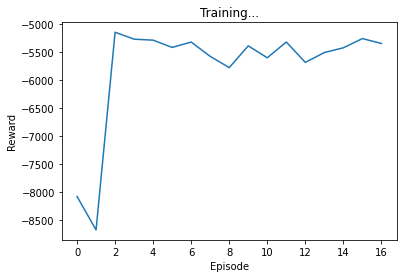

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -31.750186366384526
current_state2 [8.559782608695654, 12.878946268032616, 8.311457489656256, 0.0, 0, 1, 0, 0, 0, 1]
1
reward -29.5

reward -77.2606350061789
current_state2 [21.399456521739133, 13.77345350313847, 12.334840924542938, 27.752884056758358, 0, 1, 0, 0, 1, 0]
1
reward -72.99252219490548
current_state2 [21.399456521739133, 13.184778327406505, 11.20123865421488, 25.207048691544955, 0, 1, 0, 0, 1, 0]
1
reward -73.11538773999713
current_state2 [21.399456521739133, 12.878946268032616, 11.618313630435248, 25.218671319790136, 0, 1, 0, 0, 1, 0]
1
reward -71.02792741044006
current_state2 [21.399456521739133, 12.878946268032616, 13.508700149487106, 21.240824471181202, 0, 1, 0, 0, 1, 0]
5
reward -74.58969879073797
current_state2 [21.13215165240856, 16.09868283504077, 13.817170350132521, 21.541693953156127, 0, 1, 0, 1, 0, 0]
1
reward -70.73904473837499
current_state2 [19.972826086956523, 12.878946268032616, 14.068136609742785, 21.81913577364307, 0, 1, 0, 0, 1, 0]
1
reward -68.4421092034469
current_state2 [19.972826086956523, 6.439473134016308, 13.648075443011528, 26.381734539462542, 0, 0, 1, 0, 1, 0]
1
reward -63.856

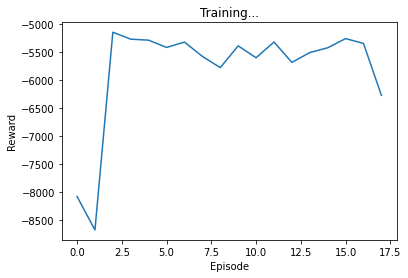

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -20.358009265804988
current_state2 [4.279891304347826, 5.356676079486579, 8.72144188197058, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -23.937342714532182
current_state2 [5.736513921880895, 6.439473134016308, 9.76135565863498, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -30.781894973494772
current_state2 [8.559782608695654, 9.65920970102446, 10.562902663774658, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -24.51753

reward -63.12214476071415
current_state2 [15.692934782608695, 11.419439898897151, 8.378213007931738, 25.631557071276557, 0, 1, 0, 0, 1, 0]
1
reward -70.0575780367724
current_state2 [15.692934782608695, 12.68190959933489, 13.521151007339272, 26.16158264748954, 0, 1, 0, 0, 1, 0]
1
reward -58.18696603645097
current_state2 [15.692934782608695, 9.65920970102446, 9.624126853621956, 21.210694699195855, 0, 1, 0, 0, 1, 0]
1
reward -64.67210801743256
current_state2 [15.692934782608695, 9.65920970102446, 12.663863473145387, 24.65610006065403, 0, 1, 0, 0, 1, 0]
1
reward -64.923345446714
current_state2 [15.692934782608695, 9.65920970102446, 12.453649461811393, 25.11755150126945, 0, 1, 0, 0, 1, 0]
1
reward -68.7521397165485
current_state2 [17.1195652173913, 15.659856525734895, 10.199419959996039, 23.773298013426267, 0, 1, 0, 0, 1, 0]
1
reward -59.43755198072938
current_state2 [17.1195652173913, 10.022549255117495, 7.825156564079908, 22.470280944140683, 0, 0, 1, 0, 1, 0]
1
reward -63.985617634541455


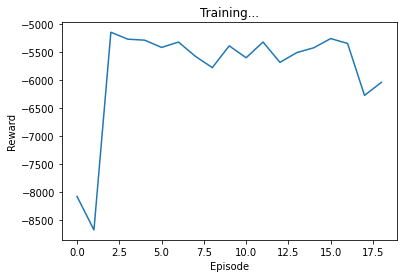

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

current_state2 [34.23913043478262, 3.219736567008154, 26.886955097034406, 13.125262671533212, 0, 1, 0, 0, 1, 0]
1
reward -85.72431232306442
current_state2 [37.09239130434784, 6.439473134016308, 24.196642034069953, 15.995805850630324, 0, 1, 0, 0, 1, 0]
1
reward -73.25228164012093
current_state2 [37.09239130434784, 6.439473134016308, 18.153636069701903, 9.566781132054869, 0, 1, 0, 0, 1, 0]
5
reward -85.76841861829782
current_state2 [38.51902173913045, 12.878946268032616, 19.35158372717627, 13.018866883958482, 0, 1, 0, 1, 0, 0]
1
reward -96.42080181493947
current_state2 [38.51902173913045, 16.09868283504077, 24.969397740078534, 14.83369950068971, 0, 1, 0, 0, 1, 0]
5
reward -95.45252144343986
current_state2 [38.51902173913045, 16.09868283504077, 26.563087090754937, 12.271729778513697, 0, 1, 0, 1, 0, 0]
5
reward -98.3499169539912
current_state2 [38.51902173913045, 12.878946268032616, 29.0629929143031, 15.88895603252503, 0, 0, 1, 1, 0, 0]
5
reward -93.55102333230097
current_state2 [38.519021

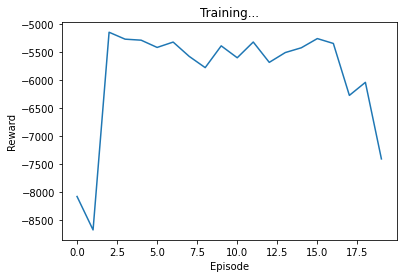

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -66.17391995791662
current_state2 [14.266304347826086, 12.878946268032616, 18.379310772983676, 18.64935856907425, 0, 1, 0, 0, 0, 1]
3
reward -62.87071008011226
current_state2 [14.266304347826086, 9.65920970102446, 21.431903644004894, 15.513292387256827, 0, 1, 0, 0, 0, 1]
3
reward -51.02135778800429
current_state2 [13.347925536748514, 3.219736567008154, 22.863797626898414, 9.589898057349208, 0, 1, 0, 0, 0, 1]
1
reward -50.3187146539546
current_state2 [12.839673913043478, 0.0, 22.2060693119429, 13.272971428968221, 0, 1, 0, 0, 1, 0]
3
reward -58.90893240162812
current_state2 [14.266304347826086, 0.0, 26.463044708846848, 16.179583344955187, 0, 1, 0, 0, 0, 1]
3
reward -60.24096487283395
current_state2 [17.1195652173913, 0.0, 27.881938379286055, 13.239461276156595, 0, 1, 0, 0, 0, 1]
3
reward -65.97968890732417
current_state2 [18.54619565217391, 0.0, 29.518203674059535, 15.915289581090724, 0, 0, 1, 0, 0, 1]
3
reward -71.3962728641248
current_state2 [21.31752210588616, 0.0, 31.705623137

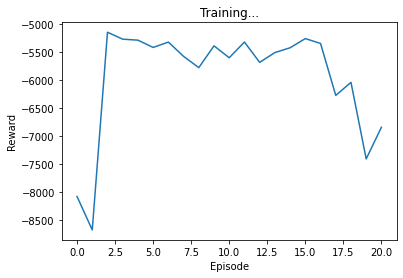

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -20.086547496934692
current_state2 [4.279891304347826, 5.356676079486579, 8.449980113100285, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -22.36779704782719
current_state2 [5.95513138901473, 6.439473134016308, 7.973192524796152, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.941349154080953
current_state2 [8.559782608695654, 6.439473134016308, 7.942093411368989, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -21.61022

reward -54.546915938715514
current_state2 [15.692934782608695, 6.439473134016308, 11.765149453016257, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -51.94802446023316
current_state2 [15.692934782608695, 4.030373164236497, 14.280306590772545, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -51.452477869374405
current_state2 [15.692934782608695, 6.439473134016308, 14.780467671859316, 12.539602280890087, 0, 1, 0, 0, 1, 0]
1
reward -56.482744563540344
current_state2 [18.54619565217391, 11.217579905113762, 10.899350524393174, 13.819618481859498, 0, 1, 0, 0, 1, 0]
1
reward -59.2185782279034
current_state2 [19.6581674189498, 12.878946268032616, 12.40973476240729, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -55.05383548528691
current_state2 [18.54619565217391, 12.878946268032616, 8.957686440473655, 12.67100712460673, 0, 1, 0, 0, 1, 0]
1
reward -63.773177057470015
current_state2 [18.54619565217391, 16.09868283504077, 11.183888647639911, 15.94440992261542, 0, 0, 1, 0, 1, 0]
1
reward -60.9643492

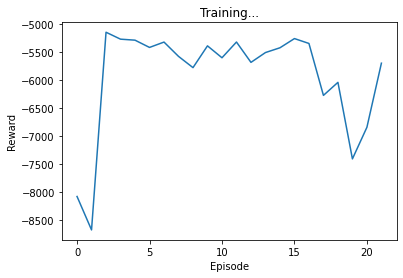

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -48.1254174144955
current_state2 [15.692934782608695, 6.439473134016308, 12.059526104353116, 11.933483393517387, 0, 1, 0, 0, 1, 0]
1
reward -54.560129314538045
current_state2 [15.692934782608695, 12.641551822664804, 9.73249208689943, 14.493150622365121, 0, 1, 0, 0, 1, 0]
1
reward -58.02162067448609
current_state2 [17.1195652173913, 13.378206897431433, 12.14140835922394, 13.38244020043941, 0, 1, 0, 0, 1, 0]
1
reward -61.42382237727856
current_state2 [15.692934782608695, 16.09868283504077, 12.99607521298116, 14.636129546647938, 0, 1, 0, 0, 1, 0]
1
reward -57.22135437446564
current_state2 [15.692934782608695, 13.783270597728919, 9.727495713695658, 16.01765328043237, 0, 1, 0, 0, 1, 0]
1
reward -59.917757608647534
current_state2 [15.692934782608695, 12.878946268032616, 11.294976671924655, 18.050899886081563, 0, 1, 0, 0, 1, 0]
1
reward -59.81672411818562
current_state2 [15.692934782608695, 12.878946268032616, 10.75199866059885, 18.492844406945462, 0, 0, 1, 0, 1, 0]
1
reward -60.489065

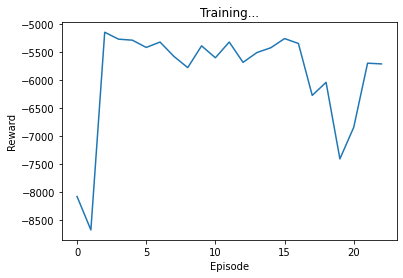

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.70651729516435
current_state2 [5.8946060775001845, 6.439473134016308, 7.3724380836478565, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -31.1203255242111
current_state2 [8.559782608695654, 12.878946268032616, 7.68159664748283, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -25.38254

reward -69.56562836512506
current_state2 [21.399456521739133, 16.09868283504077, 10.63540514137531, 19.43208386696985, 0, 1, 0, 0, 1, 0]
1
reward -66.47661663865343
current_state2 [21.399456521739133, 16.625146985789343, 11.618313630435246, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -60.766850810791304
current_state2 [21.399456521739133, 16.09868283504077, 8.029250177854806, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -73.17260295620427
current_state2 [21.399456521739133, 18.71874741001723, 12.405040455373657, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -65.91086549289025
current_state2 [21.399456521739133, 13.719172241282296, 12.847826807253412, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -65.83140799233452
current_state2 [21.399456521739133, 12.878946268032616, 10.501392735025192, 19.05161246753758, 0, 1, 0, 0, 1, 0]
1
reward -66.31337602706736
current_state2 [21.399456521739133, 12.197375378101928, 11.092816957120853, 19.623727170105454, 0, 0, 1, 0, 1, 0]
3
reward -66.8563

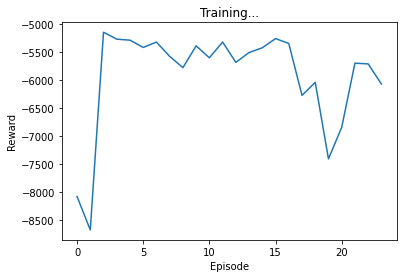

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -20.086547496934692
current_state2 [4.279891304347826, 5.356676079486579, 8.449980113100285, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -22.36779704782719
current_state2 [5.95513138901473, 6.439473134016308, 7.973192524796152, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.941349154080953
current_state2 [8.559782608695654, 6.439473134016308, 7.942093411368989, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -22.25835

reward -67.85978051549112
current_state2 [21.399456521739133, 9.65920970102446, 13.589786001477272, 21.211328291250258, 0, 1, 0, 1, 0, 0]
5
reward -76.57052939718106
current_state2 [22.826086956521742, 12.878946268032616, 16.4024216840211, 22.46307448860561, 0, 1, 0, 1, 0, 0]
5
reward -74.6690825339903
current_state2 [22.826086956521742, 9.65920970102446, 16.271495886941555, 23.91228998950255, 0, 1, 0, 1, 0, 0]
5
reward -72.37346901215767
current_state2 [22.826086956521742, 9.65920970102446, 15.172628265421356, 22.715544089190114, 0, 1, 0, 1, 0, 0]
5
reward -74.56356884318001
current_state2 [21.788422429595244, 16.09868283504077, 15.120746901990756, 19.555716676553242, 0, 1, 0, 1, 0, 0]
1
reward -82.90289116579429
current_state2 [22.826086956521742, 16.09868283504077, 18.52894396311207, 23.44917741111971, 0, 1, 0, 0, 1, 0]
5
reward -80.18069265070595
current_state2 [22.826086956521742, 14.891006680473609, 18.576595573698924, 21.88700344001167, 0, 0, 1, 1, 0, 0]
1
reward -78.40830784895

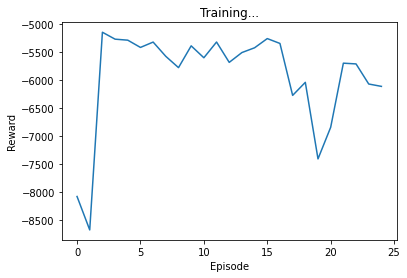

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -14.151938785135611
current_state2 [4.279891304347826, 0.0, 7.872047480787785, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -17.68257092664422
current_state2 [5.742835196761785, 3.219736567008154, 6.719999162874282, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -28.028326937089922
current_state2 [8.559782608695654, 9.65920970102446, 7.809334627369808, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -32.69606889631088
curre

reward -69.88237952206701
current_state2 [21.399456521739133, 13.669667816316815, 18.965785331776694, 13.847469852234374, 0, 1, 0, 0, 1, 0]
1
reward -69.90883708036796
current_state2 [21.399456521739133, 12.878946268032616, 17.86062793057107, 15.769806360025148, 0, 1, 0, 0, 1, 0]
1
reward -61.660185606642365
current_state2 [21.399456521739133, 12.878946268032616, 12.142321540714025, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -69.60120354294367
current_state2 [21.399456521739133, 16.09868283504077, 16.570389368355563, 13.5326748178082, 0, 1, 0, 0, 1, 0]
1
reward -66.39421039278382
current_state2 [21.399456521739133, 16.09868283504077, 14.624341257490219, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -59.67759942139644
current_state2 [19.972826086956523, 16.09868283504077, 10.588050067093972, 11.018040432305169, 0, 1, 0, 0, 1, 0]
1
reward -66.23014043925929
current_state2 [19.972826086956523, 16.09868283504077, 13.641138454197172, 14.51749306306482, 0, 0, 1, 0, 1, 0]
1
reward -67.37

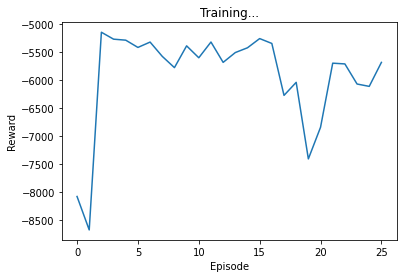

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -25.25

reward -69.43062294346163
current_state2 [25.67934782608696, 6.439473134016308, 19.61973376991744, 15.692068213440924, 0, 1, 0, 0, 1, 0]
1
reward -79.11317135004896
current_state2 [28.532608695652183, 12.878946268032616, 19.757206463748737, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -75.89960142033163
current_state2 [28.532608695652183, 16.09868283504077, 18.250269457333516, 11.018040432305169, 0, 1, 0, 0, 1, 0]
3
reward -76.79694053001596
current_state2 [28.532608695652183, 16.09868283504077, 16.687259013931502, 13.478389985391509, 0, 1, 0, 0, 0, 1]
3
reward -79.9676146666167
current_state2 [28.303753287847595, 16.09868283504077, 20.577238790015688, 12.987939753712654, 0, 1, 0, 0, 0, 1]
5
reward -81.2223070937376
current_state2 [27.105978260869573, 16.09868283504077, 23.048020450819166, 12.969625547008093, 0, 1, 0, 1, 0, 0]
5
reward -81.43163510710907
current_state2 [27.105978260869573, 18.740426086570338, 20.202790559229747, 13.38244020043941, 0, 0, 1, 1, 0, 0]
5
reward -74.208375

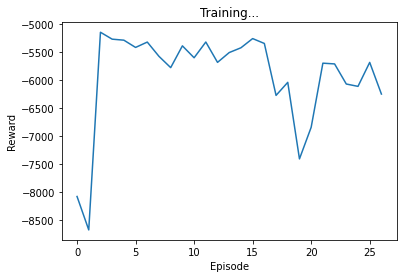

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

current_state2 [24.25271739130435, 5.276102204415436, 11.904826691280505, 24.50500305134047, 0, 1, 0, 0, 1, 0]
5
reward -78.41575505359708
current_state2 [25.67934782608696, 6.955416708893907, 18.44247580328775, 25.33851471532847, 0, 1, 0, 1, 0, 0]
1
reward -76.70232228487285
current_state2 [27.105978260869573, 12.878946268032616, 15.893817397927396, 18.82358035804326, 0, 1, 0, 0, 1, 0]
5
reward -77.54766398323939
current_state2 [27.105978260869573, 11.336646970724306, 17.56259112685139, 19.542447624794125, 0, 1, 0, 1, 0, 0]
1
reward -77.09091288329424
current_state2 [27.105978260869573, 9.65920970102446, 20.963373172005763, 17.362351749394435, 0, 1, 0, 0, 1, 0]
1
reward -72.39864078752804
current_state2 [27.105978260869573, 9.65920970102446, 18.799753324944295, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -72.89741152230121
current_state2 [28.532608695652183, 9.65920970102446, 15.893865976693132, 16.811727148931435, 0, 0, 1, 0, 1, 0]
1
reward -65.97347956246068
current_state2 [27.407

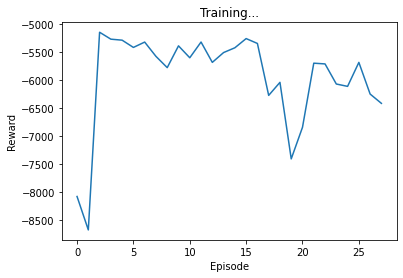

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -63.09309492362879
current_state2 [22.826086956521742, 12.878946268032616, 13.055099302407193, 12.332962396667243, 0, 1, 0, 0, 1, 0]
5
reward -58.6203768662198
current_state2 [22.826086956521742, 9.65920970102446, 11.863350430159903, 12.271729778513697, 0, 1, 0, 1, 0, 0]
1
reward -59.520837484057175
current_state2 [22.826086956521742, 6.439473134016308, 15.983547615005435, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -58.00755175814158
current_state2 [22.826086956521742, 6.439473134016308, 14.470261889089837, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -53.7826187122263
current_state2 [24.25271739130435, 6.439473134016308, 11.571125262941784, 9.519302923963858, 0, 1, 0, 0, 1, 0]
1
reward -56.20348511358316
current_state2 [25.06246607091776, 9.952816372748527, 8.43562329895565, 10.75257937096123, 0, 1, 0, 0, 1, 0]
5
reward -67.83393816377092
current_state2 [25.67934782608696, 12.878946268032616, 13.893203869211943, 13.38244020043941, 0, 0, 1, 1, 0, 0]
1
reward -69.3117012214

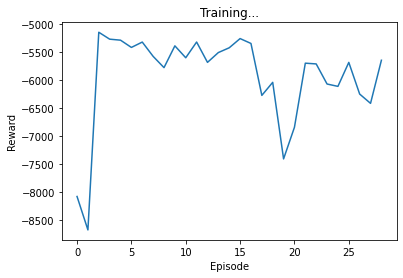

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -29.23

reward -57.17437601289234
current_state2 [12.839673913043478, 12.878946268032616, 12.220077957609792, 17.235677874206456, 0, 1, 0, 0, 1, 0]
1
reward -58.99094089506318
current_state2 [12.839673913043478, 16.09868283504077, 12.629135184159185, 15.423448962819757, 0, 1, 0, 0, 1, 0]
1
reward -48.412032230112125
current_state2 [12.839673913043478, 13.79603449956587, 8.758283385197606, 11.018040432305169, 0, 1, 0, 0, 1, 0]
1
reward -54.2217694173104
current_state2 [12.839673913043478, 12.878946268032616, 14.231419457720607, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -56.40072183565213
current_state2 [12.839673913043478, 15.13613532236382, 14.15318282173114, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -48.84707269693302
current_state2 [12.839673913043478, 12.018154279838376, 9.71751472553747, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -48.758043800486284
current_state2 [12.839673913043478, 11.027555448820706, 8.691645616262647, 14.199168822359452, 0, 0, 1, 0, 1, 0]
5
reward -54.08

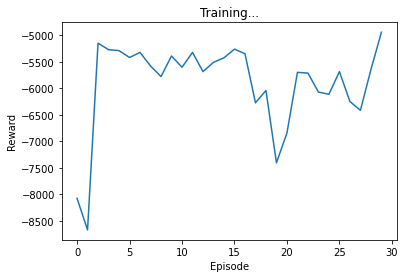

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.3959

reward -83.75451224127703
current_state2 [24.25271739130435, 16.09868283504077, 19.20604508783258, 22.19706692709933, 0, 1, 0, 0, 1, 0]
1
reward -78.38043869725065
current_state2 [24.25271739130435, 12.878946268032616, 17.47440335897326, 21.77437167894043, 0, 1, 0, 0, 1, 0]
5
reward -72.51247100848848
current_state2 [24.25271739130435, 12.878946268032616, 15.98513812628579, 17.395669222865717, 0, 1, 0, 1, 0, 0]
1
reward -77.96559500723644
current_state2 [24.25271739130435, 12.878946268032616, 21.438262125033766, 17.395669222865717, 0, 1, 0, 0, 1, 0]
1
reward -75.198250644925
current_state2 [24.25271739130435, 13.466963811974106, 18.172899834081893, 17.305669607564656, 0, 1, 0, 0, 1, 0]
1
reward -69.35339858352515
current_state2 [24.25271739130435, 12.878946268032616, 15.388035423498474, 14.83369950068971, 0, 1, 0, 0, 1, 0]
3
reward -70.68673204287418
current_state2 [24.25271739130435, 10.468580321499951, 15.45905468527845, 18.50637964479143, 0, 0, 1, 0, 0, 1]
1
reward -74.2001986280709

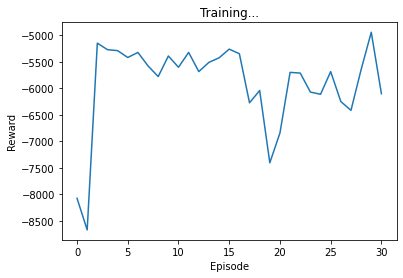

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.549374871198907
current_state2 [5.7065217391304355, 6.439473134016308, 6.403379998052165, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.538184955853634
current_state2 [8.559782608695654, 9.65920970102446, 7.319192646133518, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.602

reward -62.605558410020876
current_state2 [12.839673913043478, 13.980872849814977, 12.573683355912168, 21.211328291250258, 0, 1, 0, 0, 1, 0]
1
reward -60.51354538156643
current_state2 [12.839673913043478, 12.878946268032616, 11.481319095331758, 21.31360610515858, 0, 1, 0, 0, 1, 0]
1
reward -56.35294625846976
current_state2 [12.839673913043478, 9.65920970102446, 10.19941995999604, 21.654642684405776, 0, 1, 0, 0, 1, 0]
1
reward -60.89314198748128
current_state2 [12.839673913043478, 11.513998489543258, 15.552445335068697, 18.987024249825843, 0, 1, 0, 0, 1, 0]
5
reward -62.984340343816996
current_state2 [12.839673913043478, 12.878946268032616, 16.021970280469976, 19.243749882270922, 0, 1, 0, 1, 0, 0]
1
reward -58.771928860901866
current_state2 [14.266304347826086, 9.65920970102446, 14.800952626918297, 18.045462185133022, 0, 1, 0, 0, 1, 0]
1
reward -51.82594837169427
current_state2 [14.266304347826086, 3.219736567008154, 14.944238233994305, 17.395669222865717, 0, 0, 1, 0, 1, 0]
1
reward -49

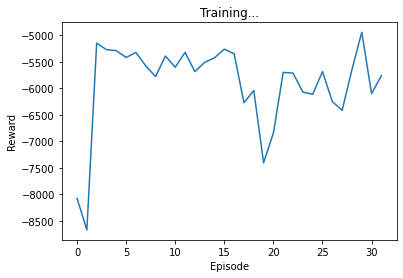

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -31.844716945263727
current_state2 [8.559782608695654, 12.878946268032616, 8.405988068535457, 0.0, 0, 1, 0, 0, 0, 1]
3
reward -29.0

reward -80.07411101750945
current_state2 [25.67934782608696, 6.439473134016308, 20.815100842576864, 25.140189214829316, 0, 1, 0, 0, 1, 0]
1
reward -85.86658436087194
current_state2 [28.532608695652183, 6.439473134016308, 22.671527026088334, 26.222975505115112, 0, 1, 0, 0, 1, 0]
1
reward -76.89107566059623
current_state2 [28.532608695652183, 3.219736567008154, 20.88559625537775, 22.253134142558135, 0, 1, 0, 0, 1, 0]
1
reward -75.30032759583466
current_state2 [27.105978260869573, 3.219736567008154, 18.3001644549483, 24.67444831300863, 0, 1, 0, 0, 1, 0]
1
reward -77.8516678598359
current_state2 [28.981264031648784, 9.65920970102446, 14.889517897007364, 22.321676230155287, 0, 1, 0, 0, 1, 0]
3
reward -84.01166686779918
current_state2 [29.959239130434796, 16.09868283504077, 14.742416611073358, 21.211328291250258, 0, 1, 0, 0, 0, 1]
1
reward -91.134105659353
current_state2 [31.3858695652174, 16.09868283504077, 18.96186647297603, 22.6876867861188, 0, 0, 1, 0, 1, 0]
1
reward -94.75796984408643
c

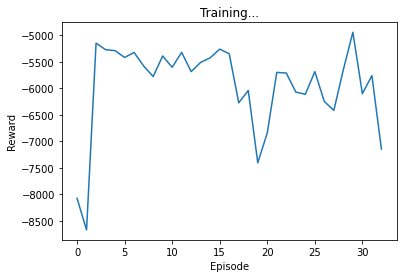

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -53.0394050579254
current_state2 [11.413043478260871, 11.698166841646751, 8.712018748330864, 19.216175989686917, 0, 1, 0, 0, 1, 0]
5
reward -60.526602910491754
current_state2 [10.834886142040471, 10.729554360551036, 15.889155559529046, 21.0730068483712, 0, 1, 0, 1, 0, 0]
5
reward -59.14102416904287
current_state2 [9.986413043478262, 12.878946268032616, 14.545155726954192, 19.7305091305778, 0, 1, 0, 1, 0, 0]
1
reward -51.45791554996115
current_state2 [11.413043478260871, 9.65920970102446, 12.441252448060396, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -55.741568854896165
current_state2 [11.413043478260871, 9.65920970102446, 16.713141224050645, 15.956174451560186, 0, 1, 0, 0, 1, 0]
1
reward -61.07594061660349
current_state2 [11.413043478260871, 12.878946268032616, 15.023881879310043, 19.760068990999958, 0, 1, 0, 0, 1, 0]
1
reward -58.66919466340195
current_state2 [12.839673913043478, 12.878946268032616, 9.885439255960835, 21.065135226365026, 0, 0, 1, 0, 1, 0]
1
reward -57.410618

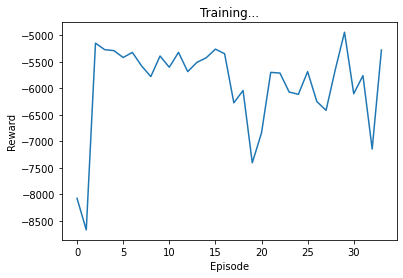

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -65.78993721746046
current_state2 [12.839673913043478, 16.09868283504077, 11.632573457252352, 23.21900701212387, 0, 1, 0, 1, 0, 0]
5
reward -69.16453031657477
current_state2 [12.839673913043478, 16.09868283504077, 12.792418063410366, 25.433755505080157, 0, 1, 0, 1, 0, 0]
5
reward -69.44378069808778
current_state2 [12.839673913043478, 16.545038981220323, 12.064348946546296, 25.99471885727769, 0, 1, 0, 1, 0, 0]
1
reward -68.27721560430516
current_state2 [12.839673913043478, 12.878946268032616, 15.674586987877081, 24.884008435351983, 0, 1, 0, 0, 1, 0]
1
reward -66.5443575851239
current_state2 [12.839673913043478, 12.878946268032616, 12.991729700627646, 25.83400770342016, 0, 1, 0, 0, 1, 0]
5
reward -59.69755393811913
current_state2 [11.413043478260871, 12.878946268032616, 11.989267071081885, 21.416297120743753, 0, 1, 0, 1, 0, 0]
5
reward -66.33658412704524
current_state2 [11.413043478260871, 12.878946268032616, 17.722555667575783, 22.32203871317597, 0, 0, 1, 1, 0, 0]
5
reward -67.12

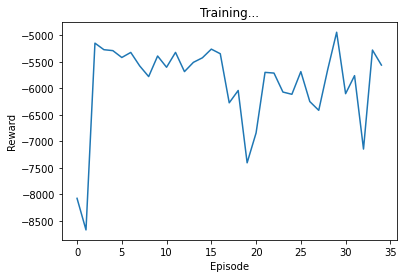

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -63.104204347554486
current_state2 [14.266304347826086, 14.688895201880166, 13.342343210983874, 18.806661586864365, 0, 1, 0, 0, 1, 0]
1
reward -59.57853800947411
current_state2 [14.266304347826086, 14.098477774077079, 13.858899476356124, 15.35485641121482, 0, 1, 0, 0, 1, 0]
1
reward -53.68819936510036
current_state2 [14.266304347826086, 12.878946268032616, 11.207136091584752, 13.335812657656911, 0, 1, 0, 0, 1, 0]
1
reward -67.48705418580477
current_state2 [14.266304347826086, 16.09868283504077, 15.363719275908833, 19.758347727029076, 0, 1, 0, 0, 1, 0]
1
reward -64.25697487673345
current_state2 [13.748209823407889, 14.971060874237626, 13.275684804216349, 20.26201937487159, 0, 1, 0, 0, 1, 0]
1
reward -59.900127770153205
current_state2 [12.839673913043478, 17.537903795096902, 10.126880839147113, 17.395669222865717, 0, 1, 0, 0, 1, 0]
1
reward -60.315158051225175
current_state2 [14.266304347826086, 13.857418664243127, 11.596000086884779, 18.595434952271184, 0, 0, 1, 0, 1, 0]
5
reward

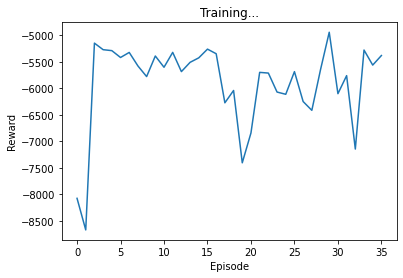

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -31.844716945263727
current_state2 [8.559782608695654, 12.878946268032616, 8.405988068535457, 0.0, 0, 1, 0, 0, 0, 1]
1
reward -27.8

reward -64.36547820959086
current_state2 [22.826086956521742, 9.65920970102446, 12.360213877091951, 17.519967674952706, 0, 1, 0, 1, 0, 0]
5
reward -78.22927091553174
current_state2 [25.67934782608696, 16.09868283504077, 16.919419122870323, 17.531821131533697, 0, 1, 0, 1, 0, 0]
1
reward -73.12371176412323
current_state2 [25.67934782608696, 16.09868283504077, 17.197726778650505, 12.147954324345, 0, 1, 0, 0, 1, 0]
1
reward -71.44705901742253
current_state2 [25.67934782608696, 15.147726608368902, 12.91602168930226, 15.703962893664396, 0, 1, 0, 0, 1, 0]
1
reward -65.51867912298178
current_state2 [25.67934782608696, 12.355667223855724, 12.466261355918029, 13.017402717121067, 0, 1, 0, 0, 1, 0]
1
reward -65.99398743050263
current_state2 [25.67934782608696, 9.963910734902036, 13.004403726874363, 15.346325142639268, 0, 1, 0, 0, 1, 0]
1
reward -67.04060389236508
current_state2 [25.67934782608696, 9.65920970102446, 11.195666720462231, 18.50637964479143, 0, 0, 1, 0, 1, 0]
5
reward -69.1605800279949

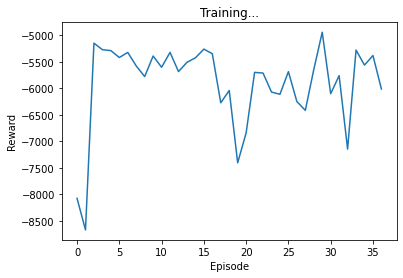

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -31.750186366384526
current_state2 [8.559782608695654, 12.878946268032616, 8.311457489656256, 0.0, 0, 1, 0, 0, 0, 1]
3
reward -30.8

reward -72.46329048635043
current_state2 [22.826086956521742, 12.878946268032616, 17.19982159372588, 17.5584356680702, 0, 1, 0, 0, 1, 0]
1
reward -64.71445809271975
current_state2 [22.826086956521742, 9.159963055259173, 14.783998158323422, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -57.76556156413211
current_state2 [22.826086956521742, 6.439473134016308, 12.56527172785076, 13.934729745743306, 0, 1, 0, 0, 1, 0]
1
reward -65.04950976364836
current_state2 [22.826086956521742, 9.65920970102446, 15.730513605412458, 14.83369950068971, 0, 1, 0, 0, 1, 0]
3
reward -71.24691773414997
current_state2 [23.803717361607614, 16.09868283504077, 17.072787758987886, 12.271729778513697, 0, 1, 0, 0, 0, 1]
1
reward -70.33940370500818
current_state2 [22.826086956521742, 16.01228931832124, 16.20893965576955, 13.292087774395645, 0, 1, 0, 0, 1, 0]
5
reward -70.76735497445512
current_state2 [22.826086956521742, 14.450018919758337, 15.98936248332925, 15.501886614845793, 0, 0, 1, 1, 0, 0]
5
reward -66.857256460

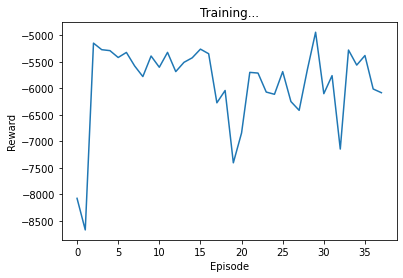

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.0918299842341
current_state2 [2.8532608695652177, 0.0, 7.238569114668882, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -14.704517485738425
current_state2 [4.279891304347826, 0.0, 8.424626181390598, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -18.150725359224047
current_state2 [5.7065217391304355, 3.219736567008154, 7.224467053085459, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.287474310326612
current_state2 [8.559782608695654, 6.439473134016308, 7.288218567614648, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -32.18730056892903
curr

reward -96.9306166575379
current_state2 [29.959239130434796, 6.439473134016308, 27.67326017975416, 30.858644213332628, 0, 1, 0, 1, 0, 0]
3
reward -95.62015961328945
current_state2 [29.959239130434796, 3.219736567008154, 29.17954668993396, 31.261637225912533, 0, 1, 0, 0, 0, 1]
3
reward -97.0193703907711
current_state2 [29.643413911186013, 6.439473134016308, 30.73129234810565, 28.20519099746313, 0, 1, 0, 0, 0, 1]
1
reward -97.38012019046218
current_state2 [29.959239130434796, 6.439473134016308, 30.768693009559968, 28.2127149164511, 0, 1, 0, 0, 1, 0]
3
reward -102.44362752072418
current_state2 [32.812500000000014, 6.439473134016308, 32.70535900898267, 28.486295377725185, 0, 1, 0, 0, 0, 1]
1
reward -99.28733744258525
current_state2 [32.812500000000014, 3.219736567008154, 34.006692672090864, 27.24840820348622, 0, 1, 0, 0, 1, 0]
1
reward -100.54396857366311
current_state2 [32.812500000000014, 3.219736567008154, 36.22367620701759, 26.288055799637352, 0, 0, 1, 0, 1, 0]
1
reward -100.2920931230

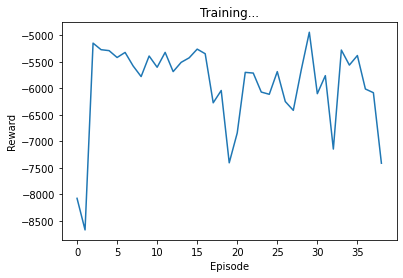

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -76.50287964474104
current_state2 [27.105978260869573, 14.59870922827005, 14.148833586527175, 18.64935856907425, 0, 1, 0, 1, 0, 0]
5
reward -74.93447641330357
current_state2 [27.105978260869573, 15.413035249698668, 14.47105298011991, 15.94440992261542, 0, 1, 0, 1, 0, 0]
5
reward -76.55138817697835
current_state2 [27.105978260869573, 16.15478039750543, 14.973356628499442, 16.31727289010391, 0, 1, 0, 1, 0, 0]
5
reward -87.16597031344486
current_state2 [27.105978260869573, 19.465780307685616, 21.19854252202395, 17.395669222865717, 0, 1, 0, 1, 0, 0]
5
reward -89.16041826235137
current_state2 [28.532608695652183, 22.08036408325812, 19.899196806121036, 16.648248677320026, 0, 1, 0, 1, 0, 0]
5
reward -88.40109160130046
current_state2 [28.532608695652183, 22.008160435196753, 19.75720646374874, 16.1031160067028, 0, 1, 0, 1, 0, 0]
1
reward -83.85763659590386
current_state2 [28.532608695652183, 18.359436198406534, 19.021181779229718, 15.94440992261542, 0, 0, 1, 0, 1, 0]
1
reward -79.6515143

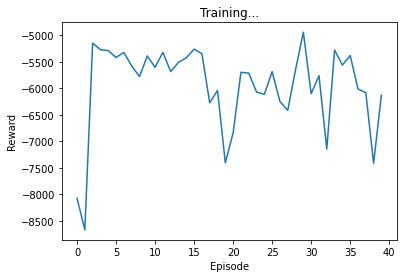

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -25.812808006843245
current_state2 [7.133152173913045, 9.65920970102446, 7.02044613190574, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -23.95591

reward -73.77203199562409
current_state2 [18.54619565217391, 14.463091621744201, 14.02839678012288, 24.734347941583092, 0, 1, 0, 1, 0, 0]
5
reward -76.14218658289437
current_state2 [18.54619565217391, 16.09868283504077, 15.222040730502902, 24.275267365176774, 0, 1, 0, 1, 0, 0]
5
reward -73.98870478017574
current_state2 [18.54619565217391, 16.09868283504077, 16.27547692599362, 21.06834936696744, 0, 1, 0, 1, 0, 0]
5
reward -74.45202337973402
current_state2 [17.1195652173913, 15.219513301708218, 16.010753048203977, 24.10219181243052, 0, 1, 0, 1, 0, 0]
1
reward -73.21911202339322
current_state2 [17.1195652173913, 16.09868283504077, 18.08307075471755, 19.91779321624359, 0, 1, 0, 0, 1, 0]
1
reward -74.0828871456969
current_state2 [17.1195652173913, 13.649169330778685, 17.54085458410064, 23.773298013426267, 0, 1, 0, 0, 1, 0]
1
reward -73.99333198646407
current_state2 [17.1195652173913, 16.09868283504077, 14.547092593346658, 24.227991340685332, 0, 0, 1, 0, 1, 0]
1
reward -71.83900266322071
cur

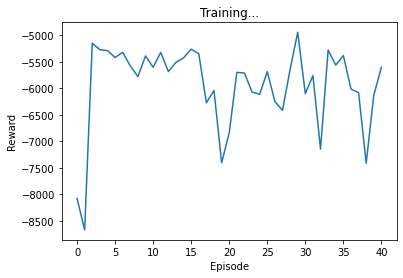

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -29.23

In [ ]:
# async def run():
for episode in range(100):
    rewards = 0
    count = 0
    reset()
    traci.simulationStep()
    previous_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#     print(previous_phase)
    for seconds in range(100): 
#         traci.simulationStep()
#             if seconds >= 300: ??
#         if seconds%time_step == 0:
#             if done(count) >= 50:
#                 print('done')
#                 break
        if current_state1 is None:
            current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#             print('current_phase', current_phase)
            current_state1 = get_state()
#             print('current_state1', current_state1)
            junct = get_action_junction(current_state1)
            current_state2 = copy.deepcopy(current_state1)
#             print('current_state2', current_state2)
            current_state2.append(int(junct))
#             print('current_state2', current_state2)
        else:
            current_state1 = next_state1
            current_state2 = next_state2
        action = get_action_phase(current_state2)
#         print('junction', junct)
#         print('action', action)
        reward, next_state1, next_state2 = take_action(action, junct) 
        if previous_state1 is not None:
            memory1.push(torch.tensor([current_state1]), torch.tensor([[junct]]), torch.tensor([next_state1]), torch.tensor([reward]))
            memory2.push(torch.tensor([current_state2]), torch.tensor([[action]]), torch.tensor([next_state2]), torch.tensor([reward]))
        optimize_model1()
        optimize_model2()
        previous_state1 = current_state1
        previous_state2 = current_state2
        rewards += reward
    reward_memory.append(rewards)
    plot_durations()

    if episode % TARGET_UPDATE == 0:
        target_net1.load_state_dict(policy_net1.state_dict())
        target_net2.load_state_dict(policy_net2.state_dict())
    traci.close()

print('Complete')
plt.ioff()
plt.show()